In [ ]:
%%writefile large_batch_training.py

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import random_split
from google.colab import files

def compute_mean_std(dataset):
    """Compute the mean and std of CIFAR-100 dataset.

    Args:
        dataset: A dataset derived from `torch.utils.data.Dataset`,
                 such as `cifar100_training_dataset` or `cifar100_test_dataset`.

    Returns:
        A tuple containing (mean, std) for the entire dataset.
    """

    # Extract images and labels
    data_r = np.stack([np.array(dataset[i][0])[:, :, 0] for i in range(len(dataset))])
    data_g = np.stack([np.array(dataset[i][0])[:, :, 1] for i in range(len(dataset))])
    data_b = np.stack([np.array(dataset[i][0])[:, :, 2] for i in range(len(dataset))])

    # Compute mean and std
    mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
    std = np.std(data_r), np.std(data_g), np.std(data_b)

    return mean, std

# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(384, 192)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model
net = LeNet5().to(device)

# Optimizer Subclasses
class LARS(optim.Optimizer):
    def __init__(self, params, lr, momentum=0.9, weight_decay=0, trust_coefficient=0.001):
        # Initialize the optimizer with the learning rate, momentum, weight decay, and trust coefficient
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, trust_coefficient=trust_coefficient)
        super(LARS, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it (commonly used for re-evaluating loss)
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                   # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                if len(state) == 0:
                    state['momentum_buffer'] = torch.clone(grad).detach()
                # Apply weight decay directly to the gradient
                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])
                # Compute the norms of the parameter and its gradient
                param_norm = torch.norm(p.data)
                grad_norm = torch.norm(grad)
                # Compute local learning rate based on the trust coefficient and norms
                if param_norm > 0 and grad_norm > 0:
                    local_lr = group['trust_coefficient'] * param_norm / (grad_norm + 1e-8)
                    grad = grad.mul(local_lr) # Scale the gradient with the local learning rate
                # Update the momentum buffer
                momentum_buffer = state['momentum_buffer']
                momentum_buffer.mul_(group['momentum']).add_(grad) #Momentum update
                state['momentum_buffer'] = momentum_buffer
                # Update the parameter
                p.data.add_(-group['lr'], momentum_buffer) # Gradient descent step with learning rate
        return loss

class LAMB(optim.Optimizer):
    def __init__(self, params, lr, weight_decay=0, betas=(0.9, 0.999), eps=1e-8):
        # Initialize the optimizer with learning rate, weight decay, betas for moment updates, and epsilon for stability
        defaults = dict(lr=lr, weight_decay=weight_decay, betas=betas, eps=eps)
        super(LAMB, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                # Initialize state
                if len(state) == 0:
                    # Initialize the state (step counter, first moment, second moment)
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data) # First moment (mean of gradients)
                    state['exp_avg_sq'] = torch.zeros_like(p.data) # Second moment (mean of squared gradients)
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']
                beta1, beta2 = group['betas']  # Coefficients for moment updates
                state['step'] += 1 # Increment step count
                step = state['step']
                # Decay the first and second moment running average coefficients
                # Update first and second moments
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1) # Exponential moving average of gradients
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2) # Exponential moving average of squared gradients
                # Correct bias in the first and second moments
                bias_correction1 = 1 - beta1 ** step
                bias_correction2 = 1 - beta2 ** step
                corrected_exp_avg = exp_avg / bias_correction1
                corrected_exp_avg_sq = exp_avg_sq / bias_correction2
                # Compute the denominator for scaling the update
                denom = corrected_exp_avg_sq.sqrt().add_(group['eps']) # Stability epsilon
                # Compute the step update
                update = corrected_exp_avg / denom
                # Apply weight decay directly to the parameters
                if group['weight_decay'] != 0:
                    update.add_(p.data, alpha=group['weight_decay'])
                # Compute the trust ratio (norm of parameters vs norm of update)
                param_norm = torch.norm(p.data)
                update_norm = torch.norm(update)
                trust_ratio = 1.0  # Default trust ratio
                if param_norm > 0 and update_norm > 0:
                    trust_ratio = param_norm / update_norm
                # Update the parameters
                p.data.add_(-group['lr'] * trust_ratio, update)
        return loss

class SqrtLRScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, base_lr, batch_size, warmup_epochs, total_epochs, reference_batch_size, verbose=False):
        """
        Args:
            optimizer: PyTorch optimizer (e.g., Adam, LAMB, LARS).
            base_lr: Base learning rate for the reference batch size.
            batch_size: Current batch size.
            warmup_epochs: Number of warmup epochs.
            total_epochs: Total number of epochs.
            reference_batch_size: Batch size for which the base_lr is defined.
            verbose: Whether to print LR updates.
        """
        self.base_lr = base_lr
        self.batch_size = batch_size
        self.scaled_lr = base_lr * (batch_size / reference_batch_size) ** 0.5
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.verbose = verbose
        super(SqrtLRScheduler, self).__init__(optimizer)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            # Linear warmup scaling
            warmup_factor = (epoch + 1) / self.warmup_epochs
            return [warmup_factor * self.scaled_lr for _ in self.optimizer.param_groups]
        else:
            # Constant LR after warmup
            return [self.scaled_lr for _ in self.optimizer.param_groups]

# Command-line arguments
parser = argparse.ArgumentParser(description='Train with Large-Batch Optimizers')
parser.add_argument('--optimizer', type=str, default='SGDM', choices=['SGDM', 'AdamW', 'LARS', 'LAMB'],
                    help='Choose optimizer')
parser.add_argument('--batch-size', type=int, default=128, help='Batch size')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGDM and LARS')
parser.add_argument('--weight-decay', type=float, default=1e-5, help='Weight decay')
parser.add_argument('--b1', type=float, default=0.9, help='Beta1 for AdamW')
parser.add_argument('--b2', type=float, default=0.999, help='Beta2 for AdamW')
parser.add_argument('--trust-coefficient', type=float, default=0.001, help='Trust coefficient for LARS')
parser.add_argument('--epochs', type=int, default=150, help='Number of epochs')
parser.add_argument('--warmup-epochs', type=int, default=5, help='Number of epochs')
args = parser.parse_args()


torch.manual_seed(42) # Set the seed for reproducibility
torch.cuda.manual_seed_all(42) # Set the seed for reproducibility on GPU

# use the same mean and std to add consistency to all datasets
data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(data)

# Load and split CIFAR-100 dataset
train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  # transforms.RandomRotation(15),
  transforms.RandomCrop(32, padding=4),
  # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
  transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.ToTensor(), # Convert into tensor
    transforms.Normalize(mean, std)  # Normalization
])

test_transform = transforms.Compose([
    transforms.CenterCrop(24),
    transforms.Pad(4),
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=val_transform)
indices = torch.randperm(len(trainset))
val_size = int(0.2*len(trainset))
trainset = torch.utils.data.Subset(trainset, indices[:-val_size])
valset = torch.utils.data.Subset(valset, indices[-val_size:])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=args.batch_size, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=2)


# Fixed parameter from paper [18] to calculate the square root LR scaling value
# base_lr = 5 / (2**3 * 10**3)
# reference_batch_size = 512
#scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5

# Mapping optimizers
if args.optimizer == 'SGDM':
    base_lr = 1e-2
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.SGD(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'AdamW':
    base_lr = 5e-4
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.AdamW(net.parameters(), lr=scaled_lr, betas=(args.b1, args.b2), weight_decay=args.weight_decay)
elif args.optimizer == 'LARS':
    base_lr = 5 / (2**3 * 10**3) # to define
    reference_batch_size = 512
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LARS(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay, trust_coefficient=args.trust_coefficient)
elif args.optimizer == 'LAMB':
    base_lr = 5 / (2**3 * 10**3) # to define
    reference_batch_size = 512
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LAMB(net.parameters(), lr=scaled_lr, weight_decay=args.weight_decay)

criterion = nn.CrossEntropyLoss()

# scheduler should be e square root LR scaling rule and linear-epoch warmup scheduling to automatically adjust learning rate
scheduler = SqrtLRScheduler(
    optimizer = optimizer,
    base_lr = base_lr,
    batch_size = args.batch_size,
    warmup_epochs = args.warmup_epochs,
    total_epochs = args.epochs,
    reference_batch_size = reference_batch_size,
    verbose = True)

# Training Function
def train_model(optimizer, scheduler, model, criterion, trainloader, valloader , testloader, device, epochs, save_checkpoint_interval=2):
    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val, total_val, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()
        val_loss /= len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct_val / total_val
        val_accuracies.append(val_accuracy)

        '''
        # Early Stopping
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1

        if epochs_no_improve == patience:
          print("Early stopping!")
          break
        '''

        # Test
        correct_test, total_test, test_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()
        test_loss /= len(testloader)
        test_losses.append(test_loss)
        test_accuracy = 100. * correct_test / total_test
        test_accuracies.append(test_accuracy)

        scheduler.step()

        # Checkpointing
        if (epoch + 1) % save_checkpoint_interval == 0:
            checkpoint_filename = f'checkpoint_epoch_{epoch + 1}.pth'
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss.item(),
            }
            checkpoint_path = os.path.join('./', checkpoint_filename)
            torch.save(checkpoint, checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch + 1}: {checkpoint_path}')

            # Download the checkpoint
            files.download(checkpoint_filename)

        print(f'Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

# Train the model
print(f"--- Train with {args.optimizer} ---")
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = train_model(optimizer, scheduler, net, criterion, trainloader, valloader, testloader, device, args.epochs)

# Save model
torch.save(net.state_dict(), f'net_{args.optimizer}.pth')

# Plot results
# Plot Training Loss
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('train_loss.png')
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(6, 4))
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('train_accuracy.png')
plt.show()

# Plot Validation Loss
plt.figure(figsize=(6, 4))
plt.plot(val_loss, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('val_loss.png')
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(6, 4))
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('val_accuracy.png')
plt.show()

# Plot Test Loss
plt.figure(figsize=(6, 4))
plt.plot(test_loss, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('test_loss.png')
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(6, 4))
plt.plot(test_acc, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('test_accuracy.png')
plt.show()

Writing large_batch_training.py


100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
--- Train with SGDM ---
Epoch 1/150, Train Acc: 1.50%, Val Acc: 3.26%, Test Acc: 3.21%
Epoch 1/150, Train Loss: 4.5983, Val Loss: 4.5759, Test Loss: 4.5764
Checkpoint saved at epoch 2: ./checkpoint_epoch_2.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 2/150, Train Acc: 4.20%, Val Acc: 7.66%, Test Acc: 7.39%
Epoch 2/150, Train Loss: 4.3721, Val Loss: 4.0852, Test Loss: 4.1128
Epoch 3/150, Train Acc: 7.53%, Val Acc: 10.99%, Test Acc: 11.04%
Epoch 3/150, Train Loss: 4.0879, Val Loss: 3.8680, Test Loss: 3.8833
Checkpoint saved at epoch 4: ./checkpoint_epoch_4.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 4/150, Train Acc: 10.32%, Val Acc: 13.57%, Test Acc: 12.69%
Epoch 4/150, Train Loss: 3.8857, Val Loss: 3.6526, Test Loss: 3.7206
Epoch 5/150, Train Acc: 13.32%, Val Acc: 18.20%, Test Acc: 15.79%
Epoch 5/150, Train Loss: 3.7030, Val Loss: 3.4198, Test Loss: 3.5933
Checkpoint saved at epoch 6: ./checkpoint_epoch_6.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 6/150, Train Acc: 15.85%, Val Acc: 20.98%, Test Acc: 18.49%
Epoch 6/150, Train Loss: 3.5403, Val Loss: 3.2760, Test Loss: 3.3918
Epoch 7/150, Train Acc: 18.66%, Val Acc: 23.69%, Test Acc: 18.86%
Epoch 7/150, Train Loss: 3.3815, Val Loss: 3.1365, Test Loss: 3.3421
Checkpoint saved at epoch 8: ./checkpoint_epoch_8.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 8/150, Train Acc: 21.47%, Val Acc: 26.82%, Test Acc: 23.24%
Epoch 8/150, Train Loss: 3.2418, Val Loss: 2.9568, Test Loss: 3.1321
Epoch 9/150, Train Acc: 23.53%, Val Acc: 28.49%, Test Acc: 24.27%
Epoch 9/150, Train Loss: 3.1159, Val Loss: 2.8435, Test Loss: 3.0585
Checkpoint saved at epoch 10: ./checkpoint_epoch_10.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 10/150, Train Acc: 25.19%, Val Acc: 30.24%, Test Acc: 24.24%
Epoch 10/150, Train Loss: 3.0287, Val Loss: 2.7868, Test Loss: 3.1320
Epoch 11/150, Train Acc: 26.96%, Val Acc: 31.69%, Test Acc: 26.27%
Epoch 11/150, Train Loss: 2.9452, Val Loss: 2.7252, Test Loss: 2.9596
Checkpoint saved at epoch 12: ./checkpoint_epoch_12.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 12/150, Train Acc: 28.45%, Val Acc: 32.62%, Test Acc: 27.05%
Epoch 12/150, Train Loss: 2.8646, Val Loss: 2.6865, Test Loss: 2.9890
Epoch 13/150, Train Acc: 29.45%, Val Acc: 32.48%, Test Acc: 28.52%
Epoch 13/150, Train Loss: 2.8158, Val Loss: 2.6616, Test Loss: 2.8677
Checkpoint saved at epoch 14: ./checkpoint_epoch_14.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 14/150, Train Acc: 30.84%, Val Acc: 34.14%, Test Acc: 29.67%
Epoch 14/150, Train Loss: 2.7510, Val Loss: 2.5832, Test Loss: 2.8429
Epoch 15/150, Train Acc: 31.37%, Val Acc: 36.05%, Test Acc: 31.40%
Epoch 15/150, Train Loss: 2.7245, Val Loss: 2.5150, Test Loss: 2.7610
Checkpoint saved at epoch 16: ./checkpoint_epoch_16.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 16/150, Train Acc: 32.63%, Val Acc: 36.63%, Test Acc: 32.24%
Epoch 16/150, Train Loss: 2.6532, Val Loss: 2.4993, Test Loss: 2.7184
Epoch 17/150, Train Acc: 33.55%, Val Acc: 37.00%, Test Acc: 32.33%
Epoch 17/150, Train Loss: 2.6163, Val Loss: 2.4725, Test Loss: 2.7072
Checkpoint saved at epoch 18: ./checkpoint_epoch_18.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 18/150, Train Acc: 34.59%, Val Acc: 38.07%, Test Acc: 32.71%
Epoch 18/150, Train Loss: 2.5706, Val Loss: 2.4240, Test Loss: 2.7156
Epoch 19/150, Train Acc: 35.25%, Val Acc: 37.08%, Test Acc: 32.34%
Epoch 19/150, Train Loss: 2.5369, Val Loss: 2.4546, Test Loss: 2.6858
Checkpoint saved at epoch 20: ./checkpoint_epoch_20.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 20/150, Train Acc: 35.78%, Val Acc: 38.35%, Test Acc: 33.87%
Epoch 20/150, Train Loss: 2.5017, Val Loss: 2.4231, Test Loss: 2.6495
Epoch 21/150, Train Acc: 36.48%, Val Acc: 38.44%, Test Acc: 33.94%
Epoch 21/150, Train Loss: 2.4659, Val Loss: 2.3950, Test Loss: 2.6144
Checkpoint saved at epoch 22: ./checkpoint_epoch_22.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 22/150, Train Acc: 37.17%, Val Acc: 39.12%, Test Acc: 33.11%
Epoch 22/150, Train Loss: 2.4335, Val Loss: 2.3715, Test Loss: 2.6717
Epoch 23/150, Train Acc: 37.73%, Val Acc: 39.71%, Test Acc: 33.10%
Epoch 23/150, Train Loss: 2.4177, Val Loss: 2.3630, Test Loss: 2.6706
Checkpoint saved at epoch 24: ./checkpoint_epoch_24.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 24/150, Train Acc: 38.75%, Val Acc: 39.91%, Test Acc: 35.03%
Epoch 24/150, Train Loss: 2.3754, Val Loss: 2.3408, Test Loss: 2.6020
Epoch 25/150, Train Acc: 38.59%, Val Acc: 39.77%, Test Acc: 33.97%
Epoch 25/150, Train Loss: 2.3693, Val Loss: 2.3521, Test Loss: 2.6522
Checkpoint saved at epoch 26: ./checkpoint_epoch_26.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 26/150, Train Acc: 38.96%, Val Acc: 38.72%, Test Acc: 34.21%
Epoch 26/150, Train Loss: 2.3471, Val Loss: 2.3769, Test Loss: 2.6154
Epoch 27/150, Train Acc: 39.54%, Val Acc: 40.43%, Test Acc: 34.62%
Epoch 27/150, Train Loss: 2.3340, Val Loss: 2.3258, Test Loss: 2.6058
Checkpoint saved at epoch 28: ./checkpoint_epoch_28.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 28/150, Train Acc: 39.92%, Val Acc: 40.13%, Test Acc: 34.18%
Epoch 28/150, Train Loss: 2.3179, Val Loss: 2.3458, Test Loss: 2.6698
Epoch 29/150, Train Acc: 40.20%, Val Acc: 41.14%, Test Acc: 35.36%
Epoch 29/150, Train Loss: 2.2980, Val Loss: 2.2802, Test Loss: 2.5988
Checkpoint saved at epoch 30: ./checkpoint_epoch_30.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 30/150, Train Acc: 41.01%, Val Acc: 42.63%, Test Acc: 37.10%
Epoch 30/150, Train Loss: 2.2530, Val Loss: 2.2496, Test Loss: 2.5209
Epoch 31/150, Train Acc: 41.05%, Val Acc: 42.28%, Test Acc: 35.85%
Epoch 31/150, Train Loss: 2.2461, Val Loss: 2.2559, Test Loss: 2.5864
Checkpoint saved at epoch 32: ./checkpoint_epoch_32.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 32/150, Train Acc: 41.76%, Val Acc: 42.31%, Test Acc: 36.10%
Epoch 32/150, Train Loss: 2.2204, Val Loss: 2.2370, Test Loss: 2.5461
Epoch 33/150, Train Acc: 42.34%, Val Acc: 43.67%, Test Acc: 37.03%
Epoch 33/150, Train Loss: 2.2057, Val Loss: 2.2325, Test Loss: 2.5383
Checkpoint saved at epoch 34: ./checkpoint_epoch_34.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 34/150, Train Acc: 42.60%, Val Acc: 43.19%, Test Acc: 37.47%
Epoch 34/150, Train Loss: 2.1884, Val Loss: 2.2225, Test Loss: 2.4926
Epoch 35/150, Train Acc: 42.51%, Val Acc: 43.39%, Test Acc: 37.27%
Epoch 35/150, Train Loss: 2.1847, Val Loss: 2.2227, Test Loss: 2.5206
Checkpoint saved at epoch 36: ./checkpoint_epoch_36.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 36/150, Train Acc: 42.87%, Val Acc: 42.33%, Test Acc: 36.66%
Epoch 36/150, Train Loss: 2.1743, Val Loss: 2.2518, Test Loss: 2.5471
Epoch 37/150, Train Acc: 43.42%, Val Acc: 43.53%, Test Acc: 37.11%
Epoch 37/150, Train Loss: 2.1472, Val Loss: 2.1781, Test Loss: 2.4928
Checkpoint saved at epoch 38: ./checkpoint_epoch_38.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 38/150, Train Acc: 43.65%, Val Acc: 44.27%, Test Acc: 38.08%
Epoch 38/150, Train Loss: 2.1434, Val Loss: 2.1751, Test Loss: 2.4733
Epoch 39/150, Train Acc: 44.06%, Val Acc: 43.88%, Test Acc: 36.53%
Epoch 39/150, Train Loss: 2.1237, Val Loss: 2.1900, Test Loss: 2.5549
Checkpoint saved at epoch 40: ./checkpoint_epoch_40.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 40/150, Train Acc: 43.97%, Val Acc: 42.87%, Test Acc: 36.47%
Epoch 40/150, Train Loss: 2.1231, Val Loss: 2.2341, Test Loss: 2.5667
Epoch 41/150, Train Acc: 44.44%, Val Acc: 44.01%, Test Acc: 37.68%
Epoch 41/150, Train Loss: 2.0998, Val Loss: 2.1795, Test Loss: 2.4913
Checkpoint saved at epoch 42: ./checkpoint_epoch_42.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 42/150, Train Acc: 44.76%, Val Acc: 44.76%, Test Acc: 37.76%
Epoch 42/150, Train Loss: 2.0876, Val Loss: 2.1880, Test Loss: 2.4907
Epoch 43/150, Train Acc: 45.26%, Val Acc: 44.62%, Test Acc: 37.98%
Epoch 43/150, Train Loss: 2.0768, Val Loss: 2.1655, Test Loss: 2.4658
Checkpoint saved at epoch 44: ./checkpoint_epoch_44.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 44/150, Train Acc: 45.11%, Val Acc: 44.33%, Test Acc: 38.69%
Epoch 44/150, Train Loss: 2.0618, Val Loss: 2.1649, Test Loss: 2.4569
Epoch 45/150, Train Acc: 45.30%, Val Acc: 44.50%, Test Acc: 36.82%
Epoch 45/150, Train Loss: 2.0525, Val Loss: 2.2147, Test Loss: 2.5891
Checkpoint saved at epoch 46: ./checkpoint_epoch_46.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 46/150, Train Acc: 45.12%, Val Acc: 44.93%, Test Acc: 39.10%
Epoch 46/150, Train Loss: 2.0688, Val Loss: 2.1587, Test Loss: 2.4191
Epoch 47/150, Train Acc: 45.57%, Val Acc: 44.31%, Test Acc: 38.17%
Epoch 47/150, Train Loss: 2.0419, Val Loss: 2.1346, Test Loss: 2.4570
Checkpoint saved at epoch 48: ./checkpoint_epoch_48.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 48/150, Train Acc: 45.78%, Val Acc: 44.67%, Test Acc: 37.61%
Epoch 48/150, Train Loss: 2.0311, Val Loss: 2.1829, Test Loss: 2.5556
Epoch 49/150, Train Acc: 46.06%, Val Acc: 43.30%, Test Acc: 37.46%
Epoch 49/150, Train Loss: 2.0284, Val Loss: 2.2164, Test Loss: 2.5087
Checkpoint saved at epoch 50: ./checkpoint_epoch_50.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 50/150, Train Acc: 46.26%, Val Acc: 44.23%, Test Acc: 38.05%
Epoch 50/150, Train Loss: 2.0158, Val Loss: 2.2047, Test Loss: 2.5004
Epoch 51/150, Train Acc: 46.34%, Val Acc: 44.17%, Test Acc: 38.71%
Epoch 51/150, Train Loss: 2.0085, Val Loss: 2.2031, Test Loss: 2.4686
Checkpoint saved at epoch 52: ./checkpoint_epoch_52.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 52/150, Train Acc: 46.57%, Val Acc: 45.20%, Test Acc: 38.51%
Epoch 52/150, Train Loss: 1.9942, Val Loss: 2.1611, Test Loss: 2.4444
Epoch 53/150, Train Acc: 46.93%, Val Acc: 45.79%, Test Acc: 39.25%
Epoch 53/150, Train Loss: 1.9971, Val Loss: 2.1633, Test Loss: 2.4648
Checkpoint saved at epoch 54: ./checkpoint_epoch_54.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 54/150, Train Acc: 46.73%, Val Acc: 44.50%, Test Acc: 35.83%
Epoch 54/150, Train Loss: 1.9940, Val Loss: 2.2163, Test Loss: 2.6568
Epoch 55/150, Train Acc: 47.45%, Val Acc: 43.22%, Test Acc: 37.96%
Epoch 55/150, Train Loss: 1.9731, Val Loss: 2.2860, Test Loss: 2.5348
Checkpoint saved at epoch 56: ./checkpoint_epoch_56.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 56/150, Train Acc: 47.51%, Val Acc: 46.11%, Test Acc: 39.14%
Epoch 56/150, Train Loss: 1.9659, Val Loss: 2.1385, Test Loss: 2.4804
Epoch 57/150, Train Acc: 47.55%, Val Acc: 45.72%, Test Acc: 38.88%
Epoch 57/150, Train Loss: 1.9647, Val Loss: 2.1579, Test Loss: 2.4499
Checkpoint saved at epoch 58: ./checkpoint_epoch_58.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 58/150, Train Acc: 47.49%, Val Acc: 44.98%, Test Acc: 39.20%
Epoch 58/150, Train Loss: 1.9606, Val Loss: 2.1892, Test Loss: 2.4411
Epoch 59/150, Train Acc: 47.95%, Val Acc: 45.18%, Test Acc: 38.35%
Epoch 59/150, Train Loss: 1.9415, Val Loss: 2.1701, Test Loss: 2.4683
Checkpoint saved at epoch 60: ./checkpoint_epoch_60.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 60/150, Train Acc: 47.89%, Val Acc: 45.68%, Test Acc: 39.67%
Epoch 60/150, Train Loss: 1.9452, Val Loss: 2.1310, Test Loss: 2.4524
Epoch 61/150, Train Acc: 48.26%, Val Acc: 45.47%, Test Acc: 39.67%
Epoch 61/150, Train Loss: 1.9364, Val Loss: 2.1612, Test Loss: 2.4553
Checkpoint saved at epoch 62: ./checkpoint_epoch_62.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 62/150, Train Acc: 47.99%, Val Acc: 45.01%, Test Acc: 37.77%
Epoch 62/150, Train Loss: 1.9415, Val Loss: 2.1916, Test Loss: 2.5865
Epoch 63/150, Train Acc: 47.70%, Val Acc: 45.17%, Test Acc: 37.70%
Epoch 63/150, Train Loss: 1.9405, Val Loss: 2.1738, Test Loss: 2.5776
Checkpoint saved at epoch 64: ./checkpoint_epoch_64.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 64/150, Train Acc: 48.28%, Val Acc: 45.24%, Test Acc: 39.16%
Epoch 64/150, Train Loss: 1.9312, Val Loss: 2.1639, Test Loss: 2.4668
Epoch 65/150, Train Acc: 49.02%, Val Acc: 45.90%, Test Acc: 38.91%
Epoch 65/150, Train Loss: 1.9120, Val Loss: 2.1832, Test Loss: 2.4836
Checkpoint saved at epoch 66: ./checkpoint_epoch_66.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 66/150, Train Acc: 48.28%, Val Acc: 45.47%, Test Acc: 39.15%
Epoch 66/150, Train Loss: 1.9155, Val Loss: 2.1630, Test Loss: 2.4503
Epoch 67/150, Train Acc: 48.62%, Val Acc: 45.77%, Test Acc: 38.70%
Epoch 67/150, Train Loss: 1.9219, Val Loss: 2.1577, Test Loss: 2.4808
Checkpoint saved at epoch 68: ./checkpoint_epoch_68.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 68/150, Train Acc: 49.11%, Val Acc: 45.69%, Test Acc: 39.34%
Epoch 68/150, Train Loss: 1.9041, Val Loss: 2.1681, Test Loss: 2.4637
Epoch 69/150, Train Acc: 48.86%, Val Acc: 45.66%, Test Acc: 38.22%
Epoch 69/150, Train Loss: 1.8973, Val Loss: 2.1471, Test Loss: 2.4586
Checkpoint saved at epoch 70: ./checkpoint_epoch_70.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 70/150, Train Acc: 48.94%, Val Acc: 46.14%, Test Acc: 38.84%
Epoch 70/150, Train Loss: 1.9008, Val Loss: 2.1368, Test Loss: 2.4904
Epoch 71/150, Train Acc: 49.10%, Val Acc: 46.68%, Test Acc: 39.44%
Epoch 71/150, Train Loss: 1.8860, Val Loss: 2.0971, Test Loss: 2.4373
Checkpoint saved at epoch 72: ./checkpoint_epoch_72.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 72/150, Train Acc: 49.81%, Val Acc: 46.46%, Test Acc: 38.28%
Epoch 72/150, Train Loss: 1.8686, Val Loss: 2.1247, Test Loss: 2.4995
Epoch 73/150, Train Acc: 49.12%, Val Acc: 46.97%, Test Acc: 40.75%
Epoch 73/150, Train Loss: 1.8864, Val Loss: 2.1123, Test Loss: 2.3969
Checkpoint saved at epoch 74: ./checkpoint_epoch_74.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 74/150, Train Acc: 49.59%, Val Acc: 46.62%, Test Acc: 39.07%
Epoch 74/150, Train Loss: 1.8706, Val Loss: 2.1377, Test Loss: 2.4777
Epoch 75/150, Train Acc: 49.95%, Val Acc: 46.06%, Test Acc: 40.17%
Epoch 75/150, Train Loss: 1.8536, Val Loss: 2.1301, Test Loss: 2.4110
Checkpoint saved at epoch 76: ./checkpoint_epoch_76.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 76/150, Train Acc: 49.85%, Val Acc: 45.40%, Test Acc: 40.33%
Epoch 76/150, Train Loss: 1.8680, Val Loss: 2.1787, Test Loss: 2.4204
Epoch 77/150, Train Acc: 49.58%, Val Acc: 46.27%, Test Acc: 39.36%
Epoch 77/150, Train Loss: 1.8676, Val Loss: 2.1758, Test Loss: 2.5024
Checkpoint saved at epoch 78: ./checkpoint_epoch_78.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 78/150, Train Acc: 49.70%, Val Acc: 46.47%, Test Acc: 39.96%
Epoch 78/150, Train Loss: 1.8636, Val Loss: 2.1556, Test Loss: 2.4543
Epoch 79/150, Train Acc: 49.98%, Val Acc: 46.33%, Test Acc: 39.81%
Epoch 79/150, Train Loss: 1.8598, Val Loss: 2.1275, Test Loss: 2.4856
Checkpoint saved at epoch 80: ./checkpoint_epoch_80.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 80/150, Train Acc: 50.06%, Val Acc: 45.99%, Test Acc: 39.66%
Epoch 80/150, Train Loss: 1.8548, Val Loss: 2.1910, Test Loss: 2.4698
Epoch 81/150, Train Acc: 49.95%, Val Acc: 47.07%, Test Acc: 38.61%
Epoch 81/150, Train Loss: 1.8519, Val Loss: 2.1162, Test Loss: 2.4927
Checkpoint saved at epoch 82: ./checkpoint_epoch_82.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 82/150, Train Acc: 50.30%, Val Acc: 45.61%, Test Acc: 38.75%
Epoch 82/150, Train Loss: 1.8447, Val Loss: 2.1861, Test Loss: 2.4912
Epoch 83/150, Train Acc: 50.59%, Val Acc: 46.09%, Test Acc: 39.69%
Epoch 83/150, Train Loss: 1.8324, Val Loss: 2.1204, Test Loss: 2.4251
Checkpoint saved at epoch 84: ./checkpoint_epoch_84.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 84/150, Train Acc: 50.55%, Val Acc: 47.06%, Test Acc: 39.98%
Epoch 84/150, Train Loss: 1.8352, Val Loss: 2.0890, Test Loss: 2.4171
Epoch 85/150, Train Acc: 50.20%, Val Acc: 46.92%, Test Acc: 40.43%
Epoch 85/150, Train Loss: 1.8346, Val Loss: 2.0945, Test Loss: 2.4317
Checkpoint saved at epoch 86: ./checkpoint_epoch_86.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 86/150, Train Acc: 50.46%, Val Acc: 45.83%, Test Acc: 36.24%
Epoch 86/150, Train Loss: 1.8281, Val Loss: 2.1655, Test Loss: 2.6481
Epoch 87/150, Train Acc: 50.18%, Val Acc: 45.72%, Test Acc: 38.13%
Epoch 87/150, Train Loss: 1.8355, Val Loss: 2.1681, Test Loss: 2.5206
Checkpoint saved at epoch 88: ./checkpoint_epoch_88.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 88/150, Train Acc: 50.08%, Val Acc: 47.05%, Test Acc: 39.77%
Epoch 88/150, Train Loss: 1.8380, Val Loss: 2.1199, Test Loss: 2.4246
Epoch 89/150, Train Acc: 50.74%, Val Acc: 46.88%, Test Acc: 39.56%
Epoch 89/150, Train Loss: 1.8178, Val Loss: 2.1311, Test Loss: 2.5001
Checkpoint saved at epoch 90: ./checkpoint_epoch_90.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 90/150, Train Acc: 50.56%, Val Acc: 46.95%, Test Acc: 39.30%
Epoch 90/150, Train Loss: 1.8283, Val Loss: 2.1056, Test Loss: 2.4956
Epoch 91/150, Train Acc: 51.20%, Val Acc: 47.26%, Test Acc: 40.66%
Epoch 91/150, Train Loss: 1.7971, Val Loss: 2.1134, Test Loss: 2.3943
Checkpoint saved at epoch 92: ./checkpoint_epoch_92.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 92/150, Train Acc: 50.88%, Val Acc: 47.84%, Test Acc: 40.86%
Epoch 92/150, Train Loss: 1.8113, Val Loss: 2.0887, Test Loss: 2.4359
Epoch 93/150, Train Acc: 51.22%, Val Acc: 47.16%, Test Acc: 40.29%
Epoch 93/150, Train Loss: 1.8041, Val Loss: 2.0888, Test Loss: 2.4206
Checkpoint saved at epoch 94: ./checkpoint_epoch_94.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 94/150, Train Acc: 50.94%, Val Acc: 45.30%, Test Acc: 38.12%
Epoch 94/150, Train Loss: 1.8026, Val Loss: 2.2022, Test Loss: 2.4871
Epoch 95/150, Train Acc: 50.85%, Val Acc: 45.91%, Test Acc: 39.36%
Epoch 95/150, Train Loss: 1.8057, Val Loss: 2.2180, Test Loss: 2.5145
Checkpoint saved at epoch 96: ./checkpoint_epoch_96.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 96/150, Train Acc: 50.73%, Val Acc: 46.87%, Test Acc: 38.96%
Epoch 96/150, Train Loss: 1.8182, Val Loss: 2.1342, Test Loss: 2.4767
Epoch 97/150, Train Acc: 51.34%, Val Acc: 47.07%, Test Acc: 40.26%
Epoch 97/150, Train Loss: 1.7924, Val Loss: 2.1246, Test Loss: 2.4280
Checkpoint saved at epoch 98: ./checkpoint_epoch_98.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 98/150, Train Acc: 51.34%, Val Acc: 46.84%, Test Acc: 39.18%
Epoch 98/150, Train Loss: 1.7890, Val Loss: 2.1088, Test Loss: 2.4402
Epoch 99/150, Train Acc: 50.99%, Val Acc: 47.01%, Test Acc: 40.77%
Epoch 99/150, Train Loss: 1.8151, Val Loss: 2.1276, Test Loss: 2.4054
Checkpoint saved at epoch 100: ./checkpoint_epoch_100.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 100/150, Train Acc: 51.29%, Val Acc: 46.26%, Test Acc: 39.17%
Epoch 100/150, Train Loss: 1.7786, Val Loss: 2.1467, Test Loss: 2.4721
Epoch 101/150, Train Acc: 51.31%, Val Acc: 46.59%, Test Acc: 40.97%
Epoch 101/150, Train Loss: 1.7826, Val Loss: 2.1338, Test Loss: 2.4256
Checkpoint saved at epoch 102: ./checkpoint_epoch_102.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 102/150, Train Acc: 51.84%, Val Acc: 47.00%, Test Acc: 39.32%
Epoch 102/150, Train Loss: 1.7748, Val Loss: 2.1214, Test Loss: 2.4498
Epoch 103/150, Train Acc: 51.55%, Val Acc: 46.54%, Test Acc: 39.86%
Epoch 103/150, Train Loss: 1.7735, Val Loss: 2.1211, Test Loss: 2.4475
Checkpoint saved at epoch 104: ./checkpoint_epoch_104.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 104/150, Train Acc: 51.31%, Val Acc: 46.77%, Test Acc: 39.79%
Epoch 104/150, Train Loss: 1.7999, Val Loss: 2.1493, Test Loss: 2.4502
Epoch 105/150, Train Acc: 52.03%, Val Acc: 47.23%, Test Acc: 40.76%
Epoch 105/150, Train Loss: 1.7674, Val Loss: 2.1636, Test Loss: 2.4652
Checkpoint saved at epoch 106: ./checkpoint_epoch_106.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 106/150, Train Acc: 51.94%, Val Acc: 47.03%, Test Acc: 39.86%
Epoch 106/150, Train Loss: 1.7644, Val Loss: 2.1138, Test Loss: 2.4592
Epoch 107/150, Train Acc: 51.89%, Val Acc: 47.41%, Test Acc: 39.66%
Epoch 107/150, Train Loss: 1.7623, Val Loss: 2.1487, Test Loss: 2.5144
Checkpoint saved at epoch 108: ./checkpoint_epoch_108.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 108/150, Train Acc: 52.26%, Val Acc: 46.51%, Test Acc: 39.31%
Epoch 108/150, Train Loss: 1.7643, Val Loss: 2.1491, Test Loss: 2.4497
Epoch 109/150, Train Acc: 52.01%, Val Acc: 46.72%, Test Acc: 39.06%
Epoch 109/150, Train Loss: 1.7542, Val Loss: 2.1144, Test Loss: 2.5179
Checkpoint saved at epoch 110: ./checkpoint_epoch_110.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 110/150, Train Acc: 52.05%, Val Acc: 46.81%, Test Acc: 40.08%
Epoch 110/150, Train Loss: 1.7535, Val Loss: 2.1305, Test Loss: 2.4428
Epoch 111/150, Train Acc: 52.08%, Val Acc: 47.50%, Test Acc: 40.89%
Epoch 111/150, Train Loss: 1.7581, Val Loss: 2.1218, Test Loss: 2.4145
Checkpoint saved at epoch 112: ./checkpoint_epoch_112.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 112/150, Train Acc: 52.39%, Val Acc: 46.71%, Test Acc: 39.70%
Epoch 112/150, Train Loss: 1.7530, Val Loss: 2.1055, Test Loss: 2.4638
Epoch 113/150, Train Acc: 52.09%, Val Acc: 46.80%, Test Acc: 40.60%
Epoch 113/150, Train Loss: 1.7555, Val Loss: 2.1170, Test Loss: 2.4059
Checkpoint saved at epoch 114: ./checkpoint_epoch_114.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 114/150, Train Acc: 52.12%, Val Acc: 46.67%, Test Acc: 39.84%
Epoch 114/150, Train Loss: 1.7538, Val Loss: 2.1018, Test Loss: 2.4273
Epoch 115/150, Train Acc: 52.24%, Val Acc: 47.32%, Test Acc: 39.98%
Epoch 115/150, Train Loss: 1.7520, Val Loss: 2.0929, Test Loss: 2.4530
Checkpoint saved at epoch 116: ./checkpoint_epoch_116.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 116/150, Train Acc: 52.26%, Val Acc: 46.93%, Test Acc: 40.41%
Epoch 116/150, Train Loss: 1.7570, Val Loss: 2.1184, Test Loss: 2.4058
Epoch 117/150, Train Acc: 52.28%, Val Acc: 47.23%, Test Acc: 40.09%
Epoch 117/150, Train Loss: 1.7527, Val Loss: 2.1085, Test Loss: 2.4430
Checkpoint saved at epoch 118: ./checkpoint_epoch_118.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 118/150, Train Acc: 52.30%, Val Acc: 47.58%, Test Acc: 40.31%
Epoch 118/150, Train Loss: 1.7499, Val Loss: 2.1323, Test Loss: 2.4661
Epoch 119/150, Train Acc: 52.50%, Val Acc: 47.14%, Test Acc: 40.55%
Epoch 119/150, Train Loss: 1.7384, Val Loss: 2.1375, Test Loss: 2.4456
Checkpoint saved at epoch 120: ./checkpoint_epoch_120.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 120/150, Train Acc: 52.61%, Val Acc: 46.15%, Test Acc: 40.04%
Epoch 120/150, Train Loss: 1.7396, Val Loss: 2.1431, Test Loss: 2.4217
Epoch 121/150, Train Acc: 52.68%, Val Acc: 46.75%, Test Acc: 40.19%
Epoch 121/150, Train Loss: 1.7281, Val Loss: 2.1912, Test Loss: 2.4932
Checkpoint saved at epoch 122: ./checkpoint_epoch_122.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 122/150, Train Acc: 52.68%, Val Acc: 47.28%, Test Acc: 40.22%
Epoch 122/150, Train Loss: 1.7344, Val Loss: 2.1018, Test Loss: 2.4573
Epoch 123/150, Train Acc: 52.26%, Val Acc: 47.14%, Test Acc: 39.98%
Epoch 123/150, Train Loss: 1.7413, Val Loss: 2.1355, Test Loss: 2.4529
Checkpoint saved at epoch 124: ./checkpoint_epoch_124.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 124/150, Train Acc: 52.98%, Val Acc: 47.47%, Test Acc: 40.43%
Epoch 124/150, Train Loss: 1.7313, Val Loss: 2.1248, Test Loss: 2.4420
Epoch 125/150, Train Acc: 52.72%, Val Acc: 47.42%, Test Acc: 40.09%
Epoch 125/150, Train Loss: 1.7287, Val Loss: 2.1149, Test Loss: 2.4435
Checkpoint saved at epoch 126: ./checkpoint_epoch_126.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 126/150, Train Acc: 52.88%, Val Acc: 47.25%, Test Acc: 39.64%
Epoch 126/150, Train Loss: 1.7238, Val Loss: 2.1669, Test Loss: 2.4613
Epoch 127/150, Train Acc: 53.22%, Val Acc: 47.08%, Test Acc: 39.91%
Epoch 127/150, Train Loss: 1.7179, Val Loss: 2.0978, Test Loss: 2.4843
Checkpoint saved at epoch 128: ./checkpoint_epoch_128.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 128/150, Train Acc: 52.93%, Val Acc: 47.49%, Test Acc: 40.31%
Epoch 128/150, Train Loss: 1.7231, Val Loss: 2.0974, Test Loss: 2.4141
Epoch 129/150, Train Acc: 52.75%, Val Acc: 45.92%, Test Acc: 39.22%
Epoch 129/150, Train Loss: 1.7262, Val Loss: 2.2078, Test Loss: 2.5885
Checkpoint saved at epoch 130: ./checkpoint_epoch_130.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 130/150, Train Acc: 52.82%, Val Acc: 46.66%, Test Acc: 39.98%
Epoch 130/150, Train Loss: 1.7240, Val Loss: 2.1470, Test Loss: 2.4618
Epoch 131/150, Train Acc: 52.99%, Val Acc: 47.55%, Test Acc: 41.34%
Epoch 131/150, Train Loss: 1.7276, Val Loss: 2.1291, Test Loss: 2.4310
Checkpoint saved at epoch 132: ./checkpoint_epoch_132.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 132/150, Train Acc: 53.14%, Val Acc: 47.35%, Test Acc: 41.75%
Epoch 132/150, Train Loss: 1.7127, Val Loss: 2.1020, Test Loss: 2.3770
Epoch 133/150, Train Acc: 53.34%, Val Acc: 47.24%, Test Acc: 41.51%
Epoch 133/150, Train Loss: 1.7107, Val Loss: 2.0952, Test Loss: 2.3867
Checkpoint saved at epoch 134: ./checkpoint_epoch_134.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 134/150, Train Acc: 52.86%, Val Acc: 46.79%, Test Acc: 40.60%
Epoch 134/150, Train Loss: 1.7188, Val Loss: 2.1389, Test Loss: 2.4269
Epoch 135/150, Train Acc: 52.86%, Val Acc: 47.24%, Test Acc: 41.87%
Epoch 135/150, Train Loss: 1.7258, Val Loss: 2.1813, Test Loss: 2.4093
Checkpoint saved at epoch 136: ./checkpoint_epoch_136.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 136/150, Train Acc: 52.83%, Val Acc: 46.40%, Test Acc: 39.84%
Epoch 136/150, Train Loss: 1.7154, Val Loss: 2.2038, Test Loss: 2.5650
Epoch 137/150, Train Acc: 53.25%, Val Acc: 47.73%, Test Acc: 41.01%
Epoch 137/150, Train Loss: 1.7141, Val Loss: 2.0971, Test Loss: 2.4150
Checkpoint saved at epoch 138: ./checkpoint_epoch_138.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 138/150, Train Acc: 53.48%, Val Acc: 46.41%, Test Acc: 39.63%
Epoch 138/150, Train Loss: 1.7024, Val Loss: 2.1988, Test Loss: 2.5341
Epoch 139/150, Train Acc: 52.94%, Val Acc: 47.21%, Test Acc: 40.99%
Epoch 139/150, Train Loss: 1.7203, Val Loss: 2.1036, Test Loss: 2.4527
Checkpoint saved at epoch 140: ./checkpoint_epoch_140.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 140/150, Train Acc: 53.19%, Val Acc: 47.32%, Test Acc: 40.51%
Epoch 140/150, Train Loss: 1.7089, Val Loss: 2.1147, Test Loss: 2.4487
Epoch 141/150, Train Acc: 53.52%, Val Acc: 46.96%, Test Acc: 40.38%
Epoch 141/150, Train Loss: 1.6939, Val Loss: 2.1286, Test Loss: 2.4336
Checkpoint saved at epoch 142: ./checkpoint_epoch_142.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 142/150, Train Acc: 53.46%, Val Acc: 46.67%, Test Acc: 40.10%
Epoch 142/150, Train Loss: 1.7040, Val Loss: 2.1412, Test Loss: 2.5107
Epoch 143/150, Train Acc: 53.44%, Val Acc: 47.43%, Test Acc: 40.88%
Epoch 143/150, Train Loss: 1.7075, Val Loss: 2.1430, Test Loss: 2.4480
Checkpoint saved at epoch 144: ./checkpoint_epoch_144.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 144/150, Train Acc: 52.98%, Val Acc: 46.83%, Test Acc: 39.87%
Epoch 144/150, Train Loss: 1.7135, Val Loss: 2.1204, Test Loss: 2.4677
Epoch 145/150, Train Acc: 53.20%, Val Acc: 47.16%, Test Acc: 40.20%
Epoch 145/150, Train Loss: 1.7146, Val Loss: 2.1400, Test Loss: 2.5018
Checkpoint saved at epoch 146: ./checkpoint_epoch_146.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 146/150, Train Acc: 53.67%, Val Acc: 47.62%, Test Acc: 39.96%
Epoch 146/150, Train Loss: 1.6909, Val Loss: 2.1336, Test Loss: 2.4683
Epoch 147/150, Train Acc: 53.39%, Val Acc: 47.13%, Test Acc: 40.45%
Epoch 147/150, Train Loss: 1.7034, Val Loss: 2.1733, Test Loss: 2.4718
Checkpoint saved at epoch 148: ./checkpoint_epoch_148.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 148/150, Train Acc: 53.15%, Val Acc: 47.58%, Test Acc: 40.97%
Epoch 148/150, Train Loss: 1.7010, Val Loss: 2.1054, Test Loss: 2.4360
Epoch 149/150, Train Acc: 53.53%, Val Acc: 47.02%, Test Acc: 41.79%
Epoch 149/150, Train Loss: 1.7002, Val Loss: 2.1311, Test Loss: 2.3743
Checkpoint saved at epoch 150: ./checkpoint_epoch_150.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 150/150, Train Acc: 53.61%, Val Acc: 48.13%, Test Acc: 41.93%
Epoch 150/150, Train Loss: 1.6968, Val Loss: 2.0962, Test Loss: 2.4016


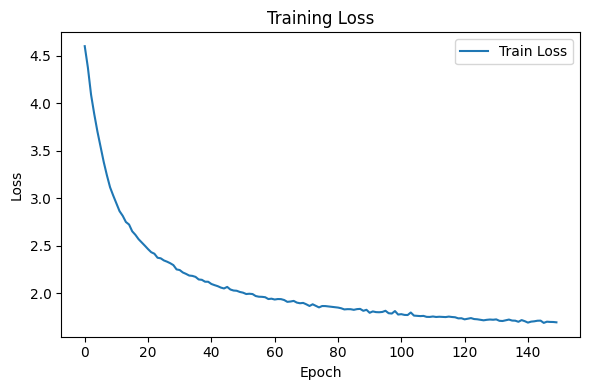

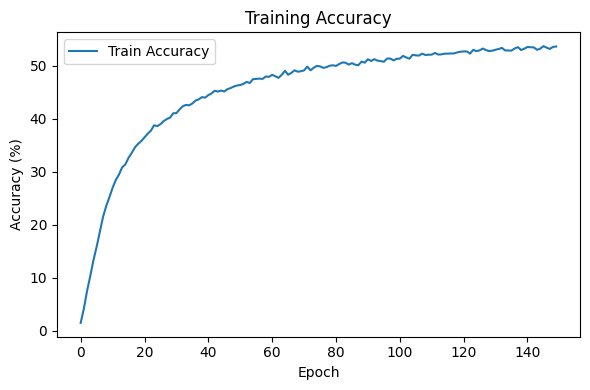

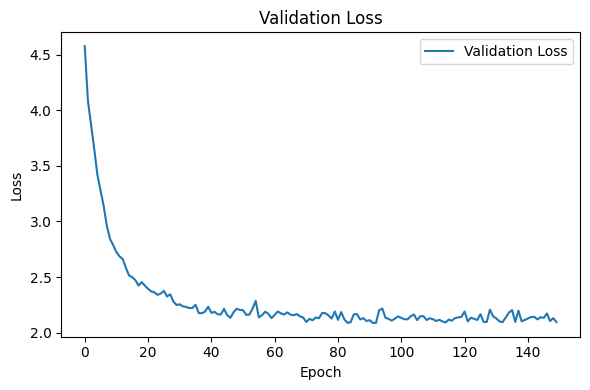

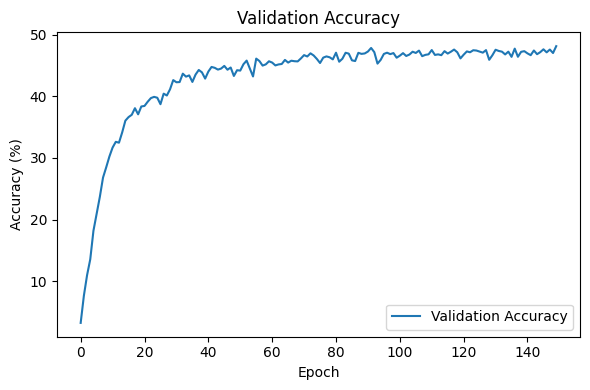

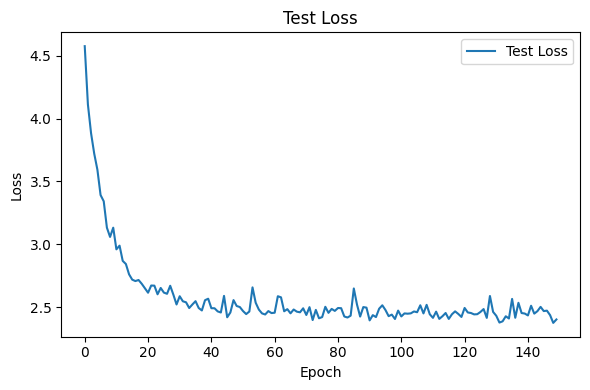

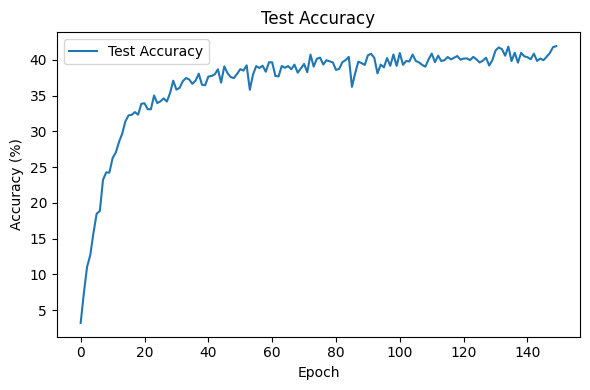

<Figure size 640x480 with 0 Axes>

In [ ]:
%run large_batch_training.py --optimizer SGDM --batch-size 128 --momentum 0.9 --weight-decay 4e-4 --epochs 150 --warmup-epochs 5

